In [1]:
!pip install cloudscraper #this isn't needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 9.8 MB/s eta 0:00:00


# Webscraper + ML Pipeline
#### by Daniel Michel
id: 2022/02556



In [63]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time
import json
import cloudscraper

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [13]:
session = requests.Session()
header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36"
}
#number of pages 55
#, 'hatchback', 'suv', 'truck', 'coupe', 'convertible'
vehicleTypes = ['sedan', 'hatchback', 'suv', 'truck', 'coupe', 'convertible']

cars = []

for vehicleType in vehicleTypes:
  for page in range(1,55):
    url = f"https://www.carsdirect.com/used_cars/listings/{vehicleType}?distance=unlimited&pageNum={page}"
    pagedata = requests.get(url, headers=header)
    time.sleep(2)
    soup = BeautifulSoup(pagedata.content, "html.parser")
    carsInPage = soup.find_all('div', class_='listingBlock')
    for car in carsInPage:
      carInfo = car.find('p', class_='ymmListRowTitle').text
      carYear = carInfo.split(' ')[0]
      carMake = carInfo.split(' ')[1]
      carModel = carInfo.split(' ')[2]
      carTrim = car.find('p', class_='ymmListRowTrim').text.strip()

      carNumberOwners = car.find('div', class_='carfaxBlock').find('span').text.strip()
      carNumberOwners = int(carNumberOwners.split(' ')[0]) if carNumberOwners else 0

      carPriceMileInfo = car.find('div', class_='infoPriceMilesBlock')
      if carPriceMileInfo:
        carMileLine = carPriceMileInfo.find('div', class_='mileLine')
        carMilage = carMileLine.text.strip() if carMileLine else 'N/A'
        carPrice = carPriceMileInfo.find('div', class_='priceLine').text.strip()
      else:
        carMilage = carPrice = "N/A"

      cars.append({
        'Year': carYear,
        'Type' : vehicleType,
        'Number_of_Owners': carNumberOwners,
        'Make': carMake,
        'Model': carModel,
        'Trim': carTrim,
        'Mileage': carMilage,
        'Price': carPrice,
      })




In [14]:
print(len(cars))
print(cars[:5])

5544
[{'Year': '2025', 'Type': 'sedan', 'Number_of_Owners': 1, 'Make': 'Kia', 'Model': 'K5', 'Trim': 'GT-Line', 'Mileage': '19,346 mi', 'Price': '$29,595'}, {'Year': '2025', 'Type': 'sedan', 'Number_of_Owners': 0, 'Make': 'Kia', 'Model': 'K5', 'Trim': 'GT-Line', 'Mileage': '122 mi', 'Price': '$31,995'}, {'Year': '2024', 'Type': 'sedan', 'Number_of_Owners': 1, 'Make': 'Kia', 'Model': 'Forte', 'Trim': 'GT-Line', 'Mileage': '11,284 mi', 'Price': '$23,495'}, {'Year': '2024', 'Type': 'sedan', 'Number_of_Owners': 1, 'Make': 'Toyota', 'Model': 'Camry', 'Trim': '', 'Mileage': '14,531 mi', 'Price': '$32,295'}, {'Year': '2023', 'Type': 'sedan', 'Number_of_Owners': 1, 'Make': 'Kia', 'Model': 'Forte', 'Trim': 'GT-Line', 'Mileage': '38,501 mi', 'Price': '$20,495'}]


In [23]:
df = pd.DataFrame(cars)


In [24]:
def format_price(price_str):
  if price_str=='Contact Dealer':
    return ''
  price = price_str.replace('$', '').replace(',', '')
  return int(price)

df["Price"] = df['Price'].apply(format_price)

In [25]:
def fixMissingTrim(trim):
  return 'base' if trim == '' else trim

df["Trim"] = df['Trim'].apply(fixMissingTrim)

In [26]:
def formatMilage(milage):
 return milage.replace('mi', '').replace(',', '').replace('N/A','')


df["Mileage"] = df['Mileage'].apply(formatMilage)

In [29]:
df['Price'] = pd.to_numeric(df['Price'])
df['Mileage'] = pd.to_numeric(df['Mileage'])
df['Year'] = pd.to_numeric(df['Year'])

In [30]:
df.head()

,Year,Type,Number_of_Owners,Make,Model,Trim,Mileage,Price
0,2025,sedan,1,Kia,K5,GT-Line,19346.0,29595.0
1,2025,sedan,0,Kia,K5,GT-Line,122.0,31995.0
2,2024,sedan,1,Kia,Forte,GT-Line,11284.0,23495.0
3,2024,sedan,1,Toyota,Camry,base,14531.0,32295.0
4,2023,sedan,1,Kia,Forte,GT-Line,38501.0,20495.0


In [31]:
df.isnull().sum()

,0
Year,0
Type,0
Number_of_Owners,0
Make,0
Model,0
Trim,0
Mileage,118
Price,554


In [32]:
df.describe()

,Year,Number_of_Owners,Mileage,Price
count,5544.000000,5544.000000,5426.000000,4990.000000
mean,2018.812410,0.065296,58595.590306,29386.498196
std,7.292291,0.247069,44995.098119,20739.822404
min,1952.000000,0.000000,1.000000,1988.000000
25%,2017.000000,0.000000,25309.500000,18498.000000
50%,2021.000000,0.000000,49475.000000,25494.500000
75%,2023.000000,0.000000,80747.000000,35993.000000
max,2025.000000,1.000000,323621.000000,699999.000000


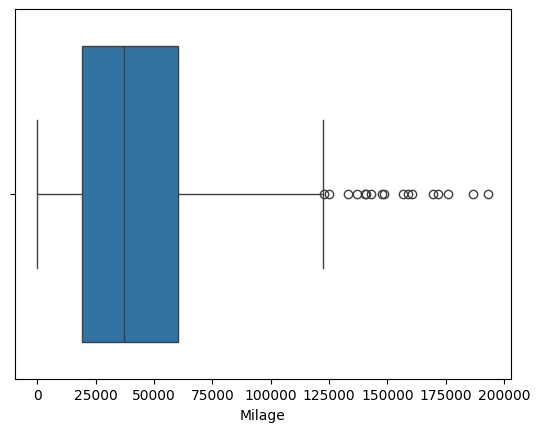

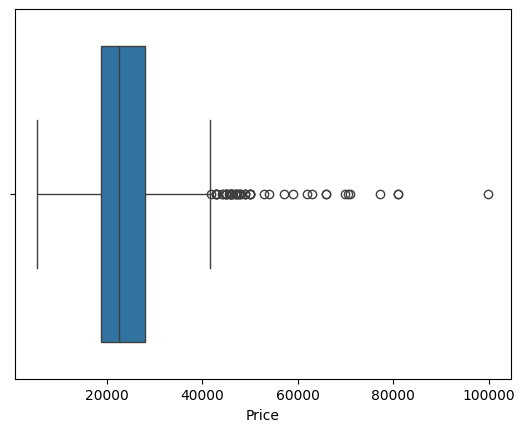

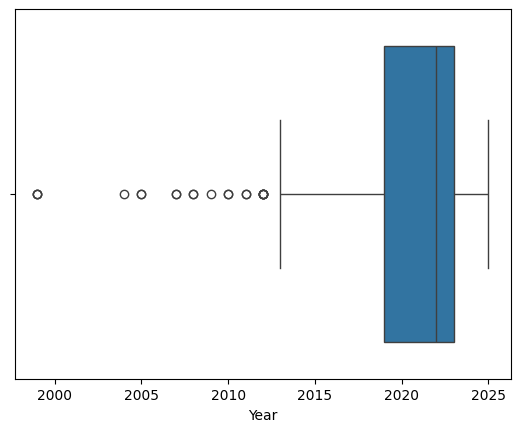

In [ ]:
sns.boxplot(x=df['Milage'])
plt.show()
sns.boxplot(x=df['Price'])
plt.show()
sns.boxplot(x=df['Year'])
plt.show()

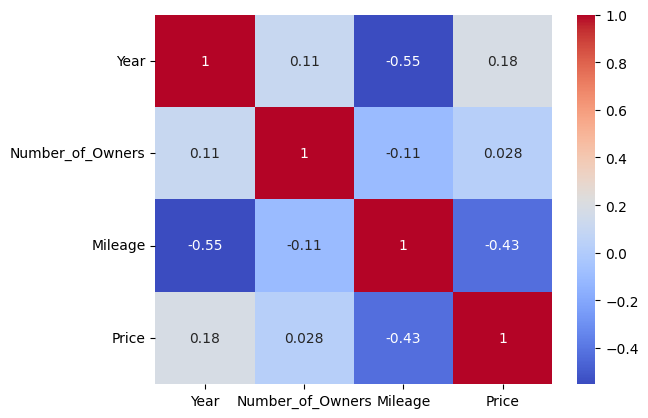

In [45]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

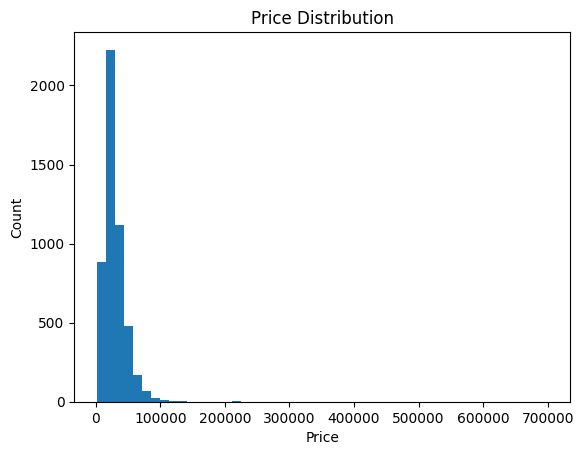

In [44]:
plt.hist(df['Price'], bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [46]:
df['Price'] = np.log1p(df['Price'])

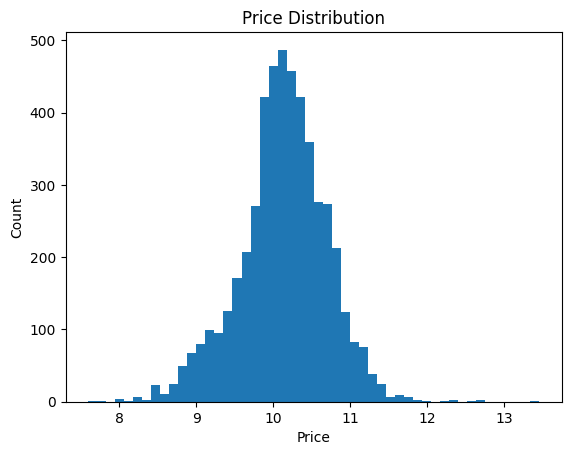

In [47]:
plt.hist(df['Price'], bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [33]:
df.to_csv('cars.csv', index=False)

In [48]:
print(df.columns)
print(df.dtypes)

Index(['Year', 'Type', 'Number_of_Owners', 'Make', 'Model', 'Trim', 'Mileage',
       'Price'],
      dtype='object')
Year                  int64
Type                 object
Number_of_Owners      int64
Make                 object
Model                object
Trim                 object
Mileage             float64
Price               float64
dtype: object


In [49]:
y = df['Price']
X = df.drop(columns='Price')

In [50]:
price_imputer = SimpleImputer(strategy='mean')
y_imputed = price_imputer.fit_transform(y.values.reshape(-1, 1))

In [51]:
print(len(y_imputed))
print(len(X))

5544
5544


In [52]:

X_train, X_test, y_train, y_test = train_test_split(X, y_imputed, test_size=0.2)

In [81]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

dataPreprocessor = ColumnTransformer([
    ('num', num_transformer, ['Mileage']),
    ('cat', cat_transformer, ['Make', 'Model', 'Trim'])
])

# I AM STILL WORKING ON IT 😭😭😭
## I WILL EDIT MY SUBMISSION, TRUST ME


In [ ]:
model = Pipeline(steps=[##da mesh sh8alll
      ('preprocessor', dataPreprocessor),
      ('model', model)
])

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Milage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Model', 'Trim'])])),
                ('model', RandomForestRegressor())])

In [88]:
models = {
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

results={}
for name, model in models.items():

  model_pipeline = Pipeline(steps=[
      ('preprocessor', dataPreprocessor),

      ('model', model)
  ])

  model_pipeline.fit(X_train, y_train)

  test_score = model_pipeline.score(X_test, y_test)
  print(f"Test score (R^2): {test_score}")
  predictions = model_pipeline.predict(X_test)

  MSE = mean_squared_error(y_test, predictions)
  print(f"Mean Squared Error (MSE): {MSE}")

  results[name] = {'MSE': MSE, 'R2': test_score}
  predictions = np.expm1(predictions)
  print(f"Predictions: {predictions[:5]}")



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test score (R^2): 0.5978079163115405
Mean Squared Error (MSE): 0.11153308860639617
Predictions: [29908.99870917  8471.37848931 22643.0763974  15623.62069966
 24894.51298748]
Test score (R^2): 0.5966002381617921
Mean Squared Error (MSE): 0.111867993443032
Predictions: [[27640.04649238]
 [ 7692.91686452]
 [22718.97927445]
 [15135.06129455]
 [25566.70858514]]


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Test score (R^2): 0.5340153442276144
Mean Squared Error (MSE): 0.12922359740362488
Predictions: [25999.68515345 12425.92610581 22200.52776115 17390.16776808
 23746.32196683]
Test score (R^2): 0.618234711712619
Mean Squared Error (MSE): 0.10586847293191669
Predictions: [29361.053   8002.0073 21372.127  13864.381  23794.629 ]


In [89]:
transformed_data = dataPreprocessor.transform(df)
print(transformed_data.shape)

feature_names = dataPreprocessor.get_feature_names_out()
print(len(feature_names))
if len(feature_names) == transformed_data.shape[1]:
    transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
    print(transformed_df.head())
    transformed_df.to_csv('cars_transformed.csv', index=False)
else:
    print(f"Feature names mismatch: {len(feature_names)} != {transformed_data.shape[1]}")

(5544, 1236)
1236
   num__Mileage  cat__Make_Acura  cat__Make_Alfa  cat__Make_Aston  \
0     -0.558847              0.0             0.0              0.0   
1     -0.910693              0.0             0.0              0.0   
2     -0.706401              0.0             0.0              0.0   
3     -0.646973              0.0             0.0              0.0   
4     -0.208264              0.0             0.0              0.0   

   cat__Make_Audi  cat__Make_Austin-Healey  cat__Make_BMW  cat__Make_Bentley  \
0             0.0                      0.0            0.0                0.0   
1             0.0                      0.0            0.0                0.0   
2             0.0                      0.0            0.0                0.0   
3             0.0                      0.0            0.0                0.0   
4             0.0                      0.0            0.0                0.0   

   cat__Make_Buick  cat__Make_CHEVROLET  ...  cat__Trim_w/Technology Package  \
0     

In [90]:
#This is all chat gpt tbh, bas it just sorted based on Rsqrd and MSE

# Sort models by R^2 in descending order (higher R^2 is better)
sorted_by_r2 = sorted(results.items(), key=lambda x: x[1]['R2'], reverse=True)

# Print the sorted results
print("Models sorted by R^2:")
for model_name, metrics in sorted_by_r2:
    print(f"{model_name} - R^2: {metrics['R2']}, MSE: {metrics['MSE']}")

# Sort models by MSE in ascending order (lower MSE is better)
sorted_by_mse = sorted(results.items(), key=lambda x: x[1]['MSE'])

# Print the sorted results
print("\nModels sorted by MSE:")
for model_name, metrics in sorted_by_mse:
    print(f"{model_name} - MSE: {metrics['MSE']}, R^2: {metrics['R2']}")


Models sorted by R^2:
XGBoost - R^2: 0.618234711712619, MSE: 0.10586847293191669
Random Forest - R^2: 0.5978079163115405, MSE: 0.11153308860639617
Linear Regression - R^2: 0.5966002381617921, MSE: 0.111867993443032
Gradient Boosting - R^2: 0.5340153442276144, MSE: 0.12922359740362488

Models sorted by MSE:
XGBoost - MSE: 0.10586847293191669, R^2: 0.618234711712619
Random Forest - MSE: 0.11153308860639617, R^2: 0.5978079163115405
Linear Regression - MSE: 0.111867993443032, R^2: 0.5966002381617921
Gradient Boosting - MSE: 0.12922359740362488, R^2: 0.5340153442276144


In [86]:
print(df.head())
# corr = df.corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.show()

   Year   Type  Number_of_Owners    Make  Model     Trim  Mileage      Price
0  2025  sedan                 1     Kia     K5  GT-Line  19346.0  10.295394
1  2025  sedan                 0     Kia     K5  GT-Line    122.0  10.373366
2  2024  sedan                 1     Kia  Forte  GT-Line  11284.0  10.064585
3  2024  sedan                 1  Toyota  Camry     base  14531.0  10.382699
4  2023  sedan                 1     Kia  Forte  GT-Line  38501.0   9.927985


XGBoost was The best performing model...

#Updates Made:
I noticed that while R^2 was really low, MSE Was super high (millions) and after plotting a histogram I noticed that the data was really skewed to the left. So, I decided to apply a log transformation on the price field in the DF to fix this problem which actually led to reasonable MSE values (fractions mostly 0.10..)
